In [77]:
import math
import random
import numpy as np
import pandas as pd
# from tqdm import tqdm

# **Часть первая**
**Я тут не буду брать в расчет вес рюкзака, время. Рассмотрим работу различных алгоритмов**

In [78]:
class Courier:
    def __init__(self, ln, wd):
        self.pos = [random.randint(0, wd), random.randint(0, ln)]
        self.price = random.randint(25, 40)

    def __str__(self):
        return 'Courier on {} {} cell, his price is {}'.format(self.pos[0], self.pos[1], self.price)


class Order:
    def __init__(self, pos1, pos2, price):
        self.pos1 = pos1
        self.pos2 = pos2
        self.price = price

    def __str__(self):
        return 'Order at ({},{}) cell, the point is at ({},{}), price is {}'.format(self.pos1[0], self.pos1[1],
                                                                                    self.pos2[0], self.pos2[1],
                                                                                    self.price)

**По ходу наптсания кода, функции будут изменяться с добавлением параметров. Точно так же и с классами Заказа и Курьера**

In [79]:
def dist_count(pos1, pos2):
    dist = math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)
    return dist


def income_count(order, courier):
    dst = dist_count(courier.pos, order.pos1) + dist_count(order.pos1, order.pos2)
    income = order.price - courier.price * dst / 10
    return income


def order_parse(file_name):
    raf = []
    file = open(file_name).readlines()
    for i in range(len(file)):
        buf = file[i].split(' ')
        buf[0] = list(map(int, buf[0].replace('(', '').replace(')', '').split(',')))
        buf[1] = list(map(int, buf[1].replace('(', '').replace(')', '').split(',')))
        buf[2] = int(buf[2])
        raf.append(Order(buf[0], buf[1], buf[2]))
    return raf

**Сделаем 9 курьеров на 7 заказов**

In [80]:
random.seed(43)

orders = []
workers = []

for i in range(9):
    workers.append(Courier(100, 100))

orders = order_parse('orders_v1.txt')

In [81]:
arr = np.array([0 for n in range(len(workers) * len(orders))]).reshape(len(workers), len(orders))

for i in range(len(workers)):
    buf = np.array([0 for n in range(len(orders))])
    for j in range(len(orders)):
        buf[j] = income_count(orders[j], workers[i])
    arr[i] = buf

df = pd.DataFrame(arr)
df

,0,1,2,3,4,5,6
0,391,354,-30,-11,47,576,418
1,395,248,77,75,-7,569,437
2,182,46,-196,-107,-188,372,300
3,246,110,123,10,-147,497,324
4,254,96,-44,0,-138,456,355
5,463,316,141,139,51,649,480
6,351,359,-109,-39,35,586,406
7,423,378,17,28,74,644,441
8,339,195,24,21,-57,512,388


**Таблица с моим заработком в случае отдачи заказа тому или иному курьеру**

In [82]:
res = 0


def sort_out(free_couriers, task, income):
    global res
    for n in range(len(free_couriers)):
        income += df[task][free_couriers[n]]
        buf = free_couriers.copy()
        buf.remove(free_couriers[n])
        if task + 1 < len(orders):
            sort_out(buf, task + 1, income)
        if task + 1 == len(orders):
            res = max(income, res)
        income -= df[task][free_couriers[n]]


sort_out([i for i in range(len(workers))], 0, 0)
print(res)

2099


**Штука считает все верно, но если в компании 2500 курьеров и 5000 заказов, то она умрет**

In [83]:
res = 0


def greedy_algorithm(df):
    global res
    rows = []
    columns = []
    df = df.reset_index()
    for c in df.columns:
        # print(c)
        r = list(df[c]).index(max(df[c]))
        # print(r, c)
        if r not in rows:
            rows.append(r)
            columns.append(c)
        else:
            # print(-1)
            if df[c][r] > df[columns[rows.index(r)]][r]:
                columns[rows.index(r)] = c
    # print(rows, columns)
    for r, c in zip(rows, columns):
        res += df[c][r]
        df = df.drop([c], axis=1)
        df = df.drop([r], axis=0)
    if not df.empty:
        # print(df[1][3])
        # print(df)
        greedy_algorithm(df)


greedy_algorithm(df)
print(res)

1904


**Как видно из показанного примера, жадный алгоритм быстрее, но менее эффективный, алгоритм перебора нашёл самый оптимальный способ, но это было дольше всего**

# **Часть вторая**

In [103]:
class Agent:
    def __init__(self):
        self.num = None
        self.partner = None
        self.income = 0

    def update(self, other, st=0):
        """
        Создаем пару Курьер-Заказ
        """
        self.partner = other
        self.other = other
        if st == 0:
            other.update(self, st=1)

    def count(self, other):
        """
        Для автоматического подсчета выручки
        """
        self.income = income_count(other, self)
        return self.income

    def clear(self, st=0):
        """
        Для разрыва связи Курьер-Заказ, на случай если агент нашёл лучшие условия
        """
        buf = self.other
        if self.partner:
            self.partner = None
            if st == 0:
                self.other.clear(st=1)
        return buf

    def delivered(self):
        """
        В случае, когда заказ доставлен и курьер должен остаться на рабочем месте, а заказ идет в сброс
        """
        if self.partner:
            self.partner = None
            del self.other


class Courier(Agent):
    def __init__(self, ln, wd, num):
        super().__init__()
        self.pos = [random.randint(0, wd), random.randint(0, ln)]
        self.price = random.randint(25, 40)
        self.num = num

    def __str__(self):
        return 'Courier-{} took order number {}'.format(self.num, self.partner.num)


class Order(Agent):
    def __init__(self, pos1, pos2, price, num=0):
        super().__init__()
        self.pos1 = pos1
        self.pos2 = pos2
        self.price = price
        self.num = num

    def __str__(self):
        return 'Order number {}'.format(self.num)

**Тут я написал агента, который отслеживает статус Курьера и заказа**

Идея в том, что теперь каждый курьер и заказ имеют связь друг с другом и в любой момент ее можно прервать (отдать курьеру другой заказ)

In [104]:
def order_parse(file_name):
    raf = []
    file = open(file_name).readlines()
    for i in range(len(file)):
        buf = file[i].split(' ')
        buf[0] = list(map(int, buf[0].replace('(', '').replace(')', '').split(',')))
        buf[1] = list(map(int, buf[1].replace('(', '').replace(')', '').split(',')))
        buf[2] = int(buf[2])
        raf.append(Order(buf[0], buf[1], buf[2], i))
    return raf

In [105]:
random.seed(43)

orders = []
workers = []

for i in range(9):
    workers.append(Courier(100, 100, i))

orders = order_parse('orders_v1.txt')

In [108]:
received_orders = []

for i in range(len(orders)):
    maxi = 0
    obj = None
    for j in range(len(workers)):
        if workers[j].count(orders[i]) > maxi:
            if not workers[j].partner and not orders[i].partner:
                maxi = workers[j].count(orders[i])
                obj = workers[j]
            else:
                if workers[j].income < workers[j].count(orders[i]):
                    order = worker[j].clear()
                    maxi = workers[j].count(orders[i])
                    obj = workers[j]
                    received_ordeers.remove(order)  # Убираем заказ из списка принятых и продолжаем искать вариаеты
    if obj:
        orders[i].update(obj)
        received_orders.append(orders[i])  # Добавляем заказ в список принятых

amount = 0

for i in workers:
    if i.partner:
        print(i)
        amount += i.income
    else:
        print(None)

# for i in received_orders:
#     print(i)

print('my income is {}'.format(amount))

for i in workers:
    i.delivered()  # прерываю связь всех курьеров с заказами, а заказы удаляю

del orders
del workers

Courier-0 took order number 4
Courier-1 took order number 3
None
Courier-3 took order number 2
None
Courier-5 took order number 0
Courier-6 took order number 5
Courier-7 took order number 1
Courier-8 took order number 6
my income is 2896.9277903707966


# **Часть третья**

In [110]:
def greedy_algorithm2(ordr, work):
    received_orders = []
    for i in range(len(ordr)):
        maxi = 0
        obj = None
        for j in range(len(work)):
            if work[j].count(ordr[i]) > maxi and work[j].status and work[j].time_count(ordr[i]):
                if not work[j].partner and not ordr[i].partner:
                    maxi = work[j].count(ordr[i])
                    obj = work[j]
                else:
                    if work[j].income < work[j].count(ordr[i]):
                        ordr = work[j].clear()
                        maxi = work[j].count(ordr[i])
                        obj = work[j]
                        received_ordeers.remove(ordr)  # Убираем заказ из списка принятых и продолжаем искать вариаеты
        if obj:
            ordr[i].update(obj)
            received_orders.append(ordr[i])  # Добавляем заказ в список принятых

    return received_orders

**Усложним наш алгоритм и поставим его так, чтобы он также ориентировался на то, работает ли сейчас курьер. Еще добавим оценку времени - надо учитывать, что какие-то Курьеры могут не успеть доставить продукт тк долго идти**

In [111]:
class Time:
    def __init__(self):
        self.hours = 9
        self.minutes = 0

    def __str__(self):
        if self.minutes < 10:
            return '{}:0{}'.format(self.hours, self.minutes)
        else:
            return '{}:{}'.format(self.hours, self.minutes)

    def __add__(self, other):
        h = self.hours + other[0] + (self.minutes + other[1]) // 60
        m = (self.minutes + other[1]) % 60
        return [h, m]


time = Time()

**Усложним нашу задачу и добавим новый параметр - время и посмотрим что вышло**

In [112]:
class Agent:
    def __init__(self):
        self.num = None
        self.partner = None
        self.income = 0

    def update(self, other, st=0):
        """
        Создаем пару Курьер-Заказ
        """
        self.partner = other
        self.other = other
        if st == 0:
            other.update(self, st=1)

    def count(self, other):
        """
        Для автоматического подсчета выручки
        """
        self.income = income_count(other, self)
        return self.income

    def clear(self, st=0):
        """
        Для разрыва связи Курьер-Заказ, на случай если агент нашёл лучшие условия
        """
        buf = self.other
        if self.partner:
            self.partner = None
            if st == 0:
                self.other.clear(st=1)
        return buf

    def delivered(self):
        """
        В случае, когда заказ доставлен и курьер должен остаться на рабочем месте, а заказ идет в сброс
        """
        if self.partner:
            self.partner = None
            del self.other


class Courier(Agent):
    def __init__(self, ln, wd, num=0):
        super().__init__()
        self.pos = [random.randint(0, wd), random.randint(0, ln)]
        self.price = random.randint(25, 40)
        self.start_time = [random.randint(8, 9), random.randint(0, 50)]
        self.end_time = [self.start_time[0] + 12, self.start_time[1]]
        self.status = True if time.hours > self.start_time[0] or (
                    time.hours == self.start_time[0] and time.minutes >= self.start_time[
                1]) else False  # Добавим статус курьера, чтобы проверять, работает он или нет
        self.num = num

    def time_count(self, other):
        """
        Метод для проверки, успеет ли курьер вовремя доставить заказ, если нет - то сразу его отсеиваем
        param: в себя объект заказа
        return: True/False в зависимости от возможности курьера
        """
        dist1 = math.sqrt((self.pos[0] - other.pos1[0]) ** 2 + (self.pos[1] - other.pos1[1]) ** 2)
        dist2 = math.sqrt((other.pos1[0] - other.pos2[0]) ** 2 + (other.pos1[1] - other.pos2[1]) ** 2)
        dist = dist1 + dist2
        timing = [(dist / 10) // 5, (dist / 10) % 5 / 5 * 60]

        delivery_time = time + timing
        if delivery_time[0] < other.timing[0] or (
                delivery_time[0] == other.timing[0] and delivery_time[1] < other.timing[1]):
            return True
        else:
            return False

    def __str__(self):
        return 'Courier-{} took order number {}'.format(self.num, self.partner.num)


class Order(Agent):
    """
    Пока оставим заказ в формате чтения из файла, в последствии для демонстрации сделаем рандомную генерацию
    """

    def __init__(self, pos1, pos2, price, t, num):
        super().__init__()
        self.pos1 = pos1
        self.pos2 = pos2
        self.price = price
        self.timing = [t[0], t[1]]
        self.num = num

    def __str__(self):
        return 'Order number {}'.format(self.num)

In [113]:
def order_parse(file_name):
    raf = []
    file = open(file_name).readlines()
    for i in range(len(file)):
        buf = file[i].split(' ')
        buf[0] = list(map(int, buf[0].replace('(', '').replace(')', '').split(',')))
        buf[1] = list(map(int, buf[1].replace('(', '').replace(')', '').split(',')))
        buf[2] = int(buf[2])
        buf[3] = list(map(int, buf[3].split(':')))
        raf.append(Order(buf[0], buf[1], buf[2], buf[3], i))
    return raf

**Время на часах 9 утра. Напишем алгоритм, который будет брать лишь тех курьеров, которые работают.**
Также стоит учитывать, что Расстояние важно по причине расчета времени, будем брать лишь тех курьеров, которые будут в состоянии доставить заказ вовремя.

In [114]:
random.seed(43)

orders = []
workers = []

for i in range(15):
    workers.append(Courier(100, 100, i))

orders = order_parse('orders_v2.txt')

In [115]:
received_orders = greedy_algorithm2(orders, workers)

amount = 0

for i in workers:
    if i.partner:
        print(i, end='\t')
        amount += i.income
        if i.status:
            print('ON')
        else:
            print('OFF')
    else:
        print(None, end='\t')
        if i.status:
            print('ON')
        else:
            print('OFF')

print('my income is {}'.format(amount))

for i in workers:
    i.delivered()  # прерываю связь всех курьеров с заказами, а заказы удаляю

None	OFF
None	OFF
None	OFF
None	OFF
None	OFF
Courier-5 took order number 10	ON
None	ON
None	ON
Courier-8 took order number 6	ON
Courier-9 took order number 2	ON
None	OFF
Courier-11 took order number 7	ON
None	ON
Courier-13 took order number 1	ON
None	OFF
my income is 878.8262477053449


**Упс, к сожалению вышло так, что не все заказы доставлены...**
(Попробуем сделать еще одну штуку - добавим параметры к курьеру - end_work и start_work вместо статуса, это позволит нам проверять когда курьер будет готов доставить заказ, вдруг он еще не вышел на работу, но выйдет минут через 5 и он максимально близок к заказу и он один успеет доставить заказ)

In [116]:
class Courier(Agent):
    def __init__(self, ln, wd, num=0):
        super().__init__()
        self.pos = [random.randint(0, wd), random.randint(0, ln)]
        self.price = random.randint(25, 40)
        self.start_time = [random.randint(8, 9), random.randint(0, 50)]
        self.end_time = [self.start_time[0] + 12, self.start_time[1]]
        self.start_work = True if time.hours in range(self.start_time[0] + 1, self.end_time[0]) or (
                    time.hours == self.start_time and time.minutes in range(self.start_time[1], 60)) or (
                                              time.hours == self.end_time and time.minutes in range(0, self.end_time[
                                          1] + 1)) else False  # Проверяем вышел ли Курьер на работу
        self.end_work = True if time.hours > self.end_time[0] or (
                    time.hours == self.end_time[0] and time.minutes > self.end_time[
                1]) else False  # Проверяем закончил ли Курьер работу
        if not self.end_work and not self.start_work:
            self.wait = [self.start_time[0] - time.hours, self.start_time[1] - time.minutes]
        else:
            self.wait = [0, 0]
        self.num = num

    def time_count(self, other):
        """
        Метод для проверки, успеет ли курьер вовремя доставить заказ, если нет - то сразу его отсеиваем
        param: в себя объект заказа
        return: True/False в зависимости от возможности курьера
        """

        dist1 = math.sqrt((self.pos[0] - other.pos1[0]) ** 2 + (self.pos[1] - other.pos1[1]) ** 2)
        dist2 = math.sqrt((other.pos1[0] - other.pos2[0]) ** 2 + (other.pos1[1] - other.pos2[1]) ** 2)
        dist = dist1 + dist2
        timing = [(dist / 10) // 5 + self.wait[0], (dist / 10) % 5 / 5 * 60 + self.wait[
            1]]  #  Делаем подсчёт времени для доставки Курьером продукта, если он скоро выйдет на работу

        delivery_time = time + timing
        if delivery_time[0] < other.timing[0] or (
                delivery_time[0] == other.timing[0] and delivery_time[1] < other.timing[1]):
            return True
        else:
            return False

    def __str__(self):
        return 'Courier-{} took order number {}'.format(self.num, self.partner.num)

In [117]:
def greedy_algorithm3(ordr, work):
    received_orders = []
    for i in range(len(ordr)):
        maxi = 0
        obj = None
        for j in range(len(work)):
            if work[j].count(ordr[i]) > maxi and not work[j].end_work and work[j].time_count(
                    ordr[i]):  # Теперь мы учитываем и тех Курьеров, которые скоро могут выйти
                if not work[j].partner and not ordr[i].partner:
                    maxi = work[j].count(ordr[i])
                    obj = work[j]
                else:
                    if work[j].income < work[j].count(ordr[i]):
                        ordr = work[j].clear()
                        maxi = work[j].count(ordr[i])
                        obj = work[j]
                        received_ordeers.remove(ordr)  # Убираем заказ из списка принятых и продолжаем искать вариаеты
        if obj:
            ordr[i].update(obj)
            received_orders.append(ordr[i])  # Добавляем заказ в список принятых

    return received_orders

In [118]:
random.seed(43)

orders = []
workers = []

for i in range(15):
    workers.append(Courier(100, 100, i))

orders = order_parse('orders_v2.txt')

In [119]:
received_orders = greedy_algorithm3(orders, workers)

amount = 0

for i in workers:
    if i.partner:
        print(i, end='\t')
        amount += i.income
        if i.start_work:
            print('ON')
        else:
            print('OFF')
    else:
        print(None, end='\t')
        if i.start_work:
            print('ON')
        else:
            print('OFF')

print('my income is {}'.format(amount))

for i in workers:
    i.delivered()  # прерываю связь всех курьеров с заказами, а заказы удаляю

Courier-0 took order number 1	OFF
Courier-1 took order number 7	OFF
None	OFF
None	OFF
None	OFF
None	ON
None	ON
None	ON
Courier-8 took order number 10	ON
Courier-9 took order number 2	ON
None	OFF
None	ON
None	ON
Courier-13 took order number 6	ON
None	OFF
my income is 1031.5346156709802


**Как мы видим в этом примере, я смог увеличить свою выручку, учитывая Курьеров, которые могут освободиться через некоторе время**
(В последствии можно это добавить Курьерам, которые уже взяли заказ. Это позволит высчитать через сколько они закончат, и сразу поставить им в wait-list новый заказ)

# **Часть Четвертая**

Для начала упростим классы Курьеров и Заказов, чтобы всё воспринималось легче

In [164]:
class Time:
    def __init__(self):
        self.hours = 9
        self.minutes = 0

    def update(self):
        self.minutes = (self.minutes + 1) % 60
        self.hours += (self.minutes + 1) // 60
        self.__str__()

    def __str__(self):
        if self.minutes < 10:
            return '{}:0{}'.format(self.hours, self.minutes)
        else:
            return '{}:{}'.format(self.hours, self.minutes)

    def __add__(self, other):
        h = self.hours + other[0] + (self.minutes + other[1]) // 60
        m = (self.minutes + other[1]) % 60
        return [h, m]

    def __lt__(self, other):
        if self.hours < other[0] or (self.hours == other[0] and self.minutes < other[1]):
            return True
        else:
            return False

    def __gt__(self, other):
        if self.hours > other[0] or (self.hours == other[0] and self.minutes > other[1]):
            return True
        else:
            return False


time = Time()


class Agent:
    def __init__(self):
        self.num = None
        self.partner = None
        self.income = 0

    def connect(self, other, st=0):
        """
        Создаем пару Курьер-Заказ
        """
        self.partner = other
        if st == 0:
            other.connect(self, st=1)

    def count(self, other):
        """
        Для автоматического подсчета выручки
        """
        dst = dist_count(self.pos, other.pos1) + dist_count(other.pos1, other.pos2)
        self.income = other.price - self.price * dst / 10
        return self.income

    def clear(self, st=0, delivered=False):
        """
        Для разрыва связи Курьер-Заказ, на случай если агент нашёл лучшие условия
        param: delivered (bool) - если True, то заказ был доставлен и мы удаляем его из базы, иначе просто разрываем связь Courier-Order
        """
        buf = self.other

        if delivered:
            if self.partner:
                del self.partner
                self.partner = None
        else:
            if self.partner:
                if st == 0:
                    self.partner.clear(st=1)
                self.partner = None
            return buf

    def dist_count(self, dot1, dot2):
        return math.sqrt((dot1[0] - dot2[0]) ** 2 + (dot1[1] - dot2[1]) ** 2)

    def delivered(self):
        """
        В случае, когда заказ доставлен и курьер должен остаться на рабочем месте, а заказ идет в сброс
        """
        if self.partner:
            self.partner = None
            del self.other


class Courier(Agent):
    def __init__(self, ln, wd, num=0):
        super().__init__()
        self.pos = [random.randint(0, wd), random.randint(0, ln)]
        self.price = random.randint(25, 40)
        self.start_time = [random.randint(8, 9), random.randint(0, 50)]
        self.end_time = [self.start_time[0] + 12, self.start_time[1]]
        self.start_work = self.start_time < time  # Проверяем вышел ли Курьер на работу
        self.end_work = self.end_time < time  # Проверяем закончил ли Курьер работу
        self.status = self.start_work and not self.end_work
        if not self.end_work and not self.start_work:  # Смотрим через сколько Курьер выйдет на работу
            self.wait = [self.start_time[0] - time.hours, self.start_time[1] - time.minutes]
        else:
            self.wait = [0, 0]
        self.num = num
        self.vector = None
        self.k = None
        self.b = None

    def route(self, pt=0):
        if self.partner:
            if pt == 0:
                self.k = (self.pos[1] - self.partner.pos1[1])/(self.pos[0] - self.partner.pos1[0])
                self.b = self.pos[1] - self.k*self.pos[0]
            elif pt == 1:
                self.k = (self.partner.pos2[1] - self.partner.pos1[1])/(self.partner.pos2[0] - self.partner.pos1[0])
                self.b = self.partner.pos1[1] - k*self.partner.pos1[0]

    def calculate_position(self):   # Обновлять позицию будем каждую секунду (минуту) => он будет проходить 100м за минуту (скорость 6км/ч) это 10 клеточек
        """
        В данной ситуации мы столкнемся с тем, что мы знаем график прямой, по которой идет курьер. И знаем расстояние, на которое он пройдет. Но мы не знаем где он окажется по итогу. Для этого решим следующее уравнение:
        x0, y0, k, b, s - известны
        x1, y1 - нужно найти (y1 = k*x1 + b)
        sqrt((x1-x0)^2 + (y1-y0)^2) = s
        Преобразовав его, получим это:
        x1^2 * (1+k^2) - x1 * (2*x0 + 2*y0*k - 2*k*b) + (x0^2 + y0^2 - 2*y0*b + b^2 - s^2) = 0
        Решим квадратное уравнение, найдём x1, а за тем y1
        """
        a = 1+self.k**2
        b = 2*self.pos[0]+2*self.pos[1]*self.k-2*self.k*self.b
        c = self.pos[0]**2+self.pos[1]**2-2*self.pos[1]*self.b+self.b**2-10**2
        D = b**2 - 4*a*c
        if self.pos[1] < self.partner.pos1[1]:
            x = max((b+math.sqrt(D))/(2*a), (b-math.sqrt(D))/(2*a))
        else:
            x = min((b+math.sqrt(D))/(2*a), (b-math.sqrt(D))/(2*a))
        y = self.k*x+self.b
        self.pos = [x, y]   # Обновляем позицию

    def time_count(self, other):
        """
        Метод для проверки, успеет ли курьер вовремя доставить заказ, если нет - то сразу его отсеиваем
        param: в себя объект заказа
        return: True/False в зависимости от возможности курьера
        """

        dist = self.dist_count(self.pos, other.pos1) + self.dist_count(other.pos1, other.pos2)
        timing = [(dist / 10) // 6, (
                    dist / 10) % 6 / 6 * 60]  #  Делаем подсчёт времени для доставки Курьером продукта, если он скоро выйдет на работу

        delivery_time = time + timing + self.wait
        if other.timing > delivery_time:
            return True
        else:
            return False

    def update(self):
        """
        Метод для обновления позиции Курьера и отслеживания его статуса - работает раз в секунду (минута времени в эмуляции)
        """
        self.start_work = self.start_time < time  # Проверяем вышел ли Курьер на работу
        self.end_work = self.end_time < time  # Проверяем закончил ли Курьер работу
        self.status = self.start_work and not self.end_work
        if self.partner:    # Если Курьер взялся доставлять заказ
            self.route()                # Тут нужно просчитывать его передвижение по маршруту (или в нашем случае по прямой, что по идее легче)
            self.calculate_position()   # есть начальная и конечная точка графика, просто найдём уравнение его вектора перемещения и будем высчитывать координату

    def __str__(self):
        return 'Courier-{} took order number {}'.format(self.num, self.partner.num)


class Order(Agent):
    """
    Пока оставим заказ в формате чтения из файла, в последствии для демонстрации сделаем рандомную генерацию
    """

    def __init__(self, pos1, pos2, price, t, num):
        super().__init__()
        self.pos1 = pos1
        self.pos2 = pos2
        self.price = price
        self.timing = [t[0], t[1]]
        self.num = num

    def __gt__(self, other):
        if self.timing[0] > other[0] or (self.timing[0] == other[0] and self.timing[1] > other[1]):
            return True
        else:
            return False

    def __str__(self):
        return 'Order number {}'.format(self.num)

**Проверим как работает наш код на плоскости:**

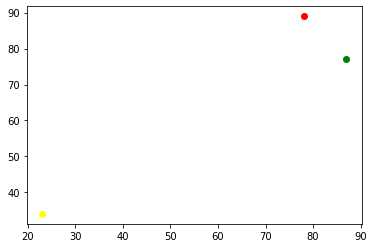

In [165]:
import matplotlib.pyplot as plt

random.seed(37)

o = Order([23, 34], [78, 89], 894, [11, 20], 7)
w = Courier(100, 100)

plt.plot([o.pos1[0]], [o.pos1[1]], color='yellow', marker='o')
plt.plot([o.pos2[0]], [o.pos2[1]], color='red', marker='o')
plt.plot([w.pos[0]], [w.pos[1]], color='green', marker='o')
plt.show()

**Теперь сделаем так, чтобы наш курьер шёл и за ним рисовался график, чтобы мы видели, пойдёт ли он в нужном направлении**

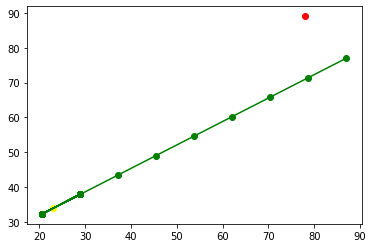

In [166]:
w.connect(o)

plt.plot([o.pos1[0]], [o.pos1[1]], color='yellow', marker='o')
plt.plot([o.pos2[0]], [o.pos2[1]], color='red', marker='o')

x = [w.pos[0]]
y = [w.pos[1]]



for i in range(20):
    w.update()
    x.append(w.pos[0])
    y.append(w.pos[1])

plt.plot(x, y, color='green', marker='o')

plt.show()

**Как видно из графика, курьер нормально двигается по отношению к цели, теперь перенесем прописанные классы в отдельный файл и сделаем библиотеку**